<a href="https://colab.research.google.com/github/truongthuanr/transfer/blob/main/08_SSSMarket_truongthuan_EffB3_20lbl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import seaborn as sns
from random import randint
from urllib.request import urlopen
from numpy import asarray

In [3]:
train_url = "https://raw.githubusercontent.com/truongthuanr/self-project/main/dataset/sss/train.csv"
df = pd.read_csv(train_url)


total_images = df.thumbnail_url.notna().sum()
# total_images

df.loc[df["cloth_type"]==' ',"cloth_type"] = np.NaN


# create a list of list of labels 
labels = df.cloth_type.str.split(" ").tolist()
labels = [item if type(item) == list else [str(item)] for item in labels]
# labels[:5]


# Count the apperence of label
all_label = [label for sub in labels for label in sub if label!='nan']
labels_count = Counter(all_label)
# labels_count

labels_count = Counter(all_label)
# sort by frequency
label_name = [tag for tag,count in labels_count.most_common()]
label_freq = [count for tag,count in labels_count.most_common()]

label_map = {label_name[i]: i for i in range(0,len(label_name))}
inv_label_map = {i:label_name[i] for i in range(0,len(label_name))}
inv_label_map

{0: 'top_t-shirt_sweatshirt',
 1: 'pants',
 2: 'shoe',
 3: 'dress',
 4: 'skirt',
 5: 'shirt_blouse',
 6: 'shorts',
 7: 'watch',
 8: 'bag_wallet',
 9: 'jacket',
 10: 'belt',
 11: 'hat',
 12: 'coat',
 13: 'glasses',
 14: 'sweater',
 15: 'headband_head-covering_hair-accessory',
 16: 'cardigan',
 17: 'jumpsuit',
 18: 'scarf',
 19: 'vest'}

# Model

In [4]:
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras import backend
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
def fbeta(y_true, y_pred, beta=1):
  # clip prediction
  y_pred = backend.clip(y_pred,0,1)
  # calculate elements
  tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
  fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
  fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
  # calculate precision
  p = tp / (tp + fp + backend.epsilon())
  # calculate recall
  r = tp / (tp + fn + backend.epsilon())
  # calculate fbeta
  bb = beta**2
  fbeta_score = backend.mean((1+bb)*(p*r)/(bb*p+r+backend.epsilon()))
  return fbeta_score

In [6]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
  # plot loss
  plt.subplot(211)
  plt.title("Cross Entropy Loss")
  plt.plot(history.history["loss"], color='blue', label='train')
  plt.plot(history.history['val_loss'],color='orange', label='test')

  # plot accuracy
  plt.subplot(212)
  plt.title("F1 Score")
  plt.plot(history.history["fbeta"], color='blue', label='train')
  plt.plot(history.history['val_fbeta'],color='orange', label='test')

In [7]:
in_shape = (280,280,3)
out_shape = 20

In [8]:
model = EfficientNetB3(include_top=False,
                       input_shape = in_shape)
for layer in model.layers:
  layer.trainable = False

flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(128, activation='relu', kernel_initializer="he_uniform")(flat1)
output = Dense(out_shape, activation="sigmoid")(class1)

model = Model(inputs=model.inputs, outputs=output)
# compile model
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])

43950080/43941136 [==============================] - 1s 0us/step


In [9]:
data = np.load("/content/drive/MyDrive/01_AI_ML/sss/sss_data_full_20label.npz")
X, y = data["arr_0"], data["arr_1"]
print(f"Loaded: {X.shape} {y.shape}")

Loaded: (4705, 280, 280, 3) (4705, 20)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=99)
datagen = ImageDataGenerator()
# datagen.mean = [123.68, 116.778, 103.939]
train_it = datagen.flow(X_train, y_train, batch_size=64)
test_it = datagen.flow(X_test, y_test, batch_size=64)

In [11]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

In [12]:
history = model.fit(train_it, 
                    steps_per_epoch=len(train_it), 
                    validation_data=test_it, 
                    validation_steps=len(test_it),
                    epochs=30)

Epoch 1/30
50/50 [==============================] - 106s 1s/step - loss: 0.2359 - fbeta: 0.5270 - val_loss: 0.1799 - val_fbeta: 0.5841
Epoch 2/30
50/50 [==============================] - 56s 1s/step - loss: 0.1225 - fbeta: 0.6983 - val_loss: 0.1747 - val_fbeta: 0.5975
Epoch 3/30
50/50 [==============================] - 56s 1s/step - loss: 0.0884 - fbeta: 0.7726 - val_loss: 0.1690 - val_fbeta: 0.6137
Epoch 4/30
50/50 [==============================] - 56s 1s/step - loss: 0.0668 - fbeta: 0.8212 - val_loss: 0.1653 - val_fbeta: 0.6336
Epoch 5/30
50/50 [==============================] - 56s 1s/step - loss: 0.0515 - fbeta: 0.8484 - val_loss: 0.1717 - val_fbeta: 0.6467
Epoch 6/30
50/50 [==============================] - 56s 1s/step - loss: 0.0419 - fbeta: 0.8705 - val_loss: 0.1721 - val_fbeta: 0.6406
Epoch 7/30
50/50 [==============================] - 56s 1s/step - loss: 0.0343 - fbeta: 0.8908 - val_loss: 0.1759 - val_fbeta: 0.6207
Epoch 8/30
50/50 [==============================] - 56s 1s/st

In [13]:
model.save_weights('/content/drive/MyDrive/01_AI_ML/sss/model_EfB3_20lb/model_EfB3_20lb')

In [14]:
loss, fbeta = model.evaluate(test_it, steps=len(test_it))

25/25 [==============================] - 19s 734ms/step - loss: 0.2251 - fbeta: 0.6382


In [15]:
print(f"> loss = {loss:.3f}, f1-mean = {fbeta:.3f}")

> loss = 0.225, f1-mean = 0.638


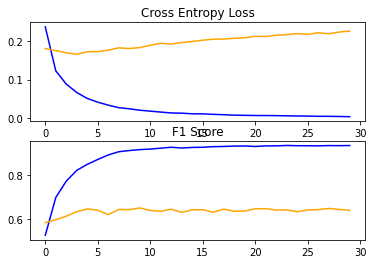

In [16]:
summarize_diagnostics(history)

In [17]:
data = np.load("/content/drive/MyDrive/01_AI_ML/sss/test_data_convrgb.npz")
test_data = data["arr_0"]
print(f"Loaded: {test_data.shape}")

Loaded: (1505, 280, 280, 3)


In [18]:
predictions = model.predict(test_data)

def prediction_to_tags(inv_label_map, prediction):
  # round the prob
  values = prediction.round()
  # Collect tags
  tags = [inv_label_map[i] for i in range(len(values)) if values[i]==1.0]
  return tags

prediction_tags = [prediction_to_tags(inv_label_map, prediction) for prediction in predictions]
prediction_tags = [" ".join(prediction) for prediction in prediction_tags]

In [19]:
submission = pd.DataFrame({"id":[i+4705 for i in range(len(test_data))],
                           "cloth_type": prediction_tags})

In [20]:
submission[0:20]

,id,cloth_type
0,4705,top_t-shirt_sweatshirt
1,4706,top_t-shirt_sweatshirt shoe skirt
2,4707,top_t-shirt_sweatshirt
3,4708,pants shoe shirt_blouse
4,4709,dress bag_wallet
5,4710,top_t-shirt_sweatshirt
6,4711,top_t-shirt_sweatshirt bag_wallet
7,4712,top_t-shirt_sweatshirt
8,4713,skirt jacket sweater
9,4714,top_t-shirt_sweatshirt pants shoe


In [21]:
submission.to_csv('/content/drive/MyDrive/01_AI_ML/sss/v6_EfB3_20.csv', index=False)